# ASH method

This notebook aims at evaluating the **ASH method**.

**ASH** method basically consists in re-using existing logit-based OOD methods, but with penultimate layer **activations scaled and pruned**. Let $a$ be the activation vector, and $P_p(a)$ the $p$-th percentile of $a$'s values. The scaling is computed using the formula
$$
s = \exp(\frac{\sum_{i} a_i}{\sum_{a_i > P_p(a)} a_i})
$$
The activation is pruned for values $a_i \leq P_p(a)$.

Here, we focus on a Resnet trained on CIFAR10, challenged on SVHN.

**Reference**  
_Extremely Simple Activation Shaping for Out-of-Distribution Detection_, ICLR 2023
<http://arxiv.org/abs/2209.09858>


### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

from oodeel.methods import MLS, Energy, ODIN, GEN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.torch_training_tools import train_torch_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [3]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.

In [4]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("torch")

# 1a- Load in-distribution dataset: CIFAR-10
ds_in = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
)
# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset(
    "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
)


# 2- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    inputs["input"] = inputs["input"].float() / 255.0
    inputs["input"] = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )(inputs["input"])
    return inputs


ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.

In [5]:
# === load model ===
# resnet20 pretrained on CIFAR-10
model = torch.hub.load(
    repo_or_dir="chenyaofo/pytorch-cifar-models",
    model="cifar10_resnet20",
    pretrained=True,
    verbose=False,
).to(device)
model.eval()

# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

Test accuracy:	0.925900


### SCALE scores

We now fit some OOD detectors using SCALE + [MLS, MSP, Energy, Entropy, ODIN] with MNIST[0-4] train dataset, and compare OOD scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.

=== ODIN ===
~ Without ASH ~


auroc      0.872446
fpr95tpr   0.489400


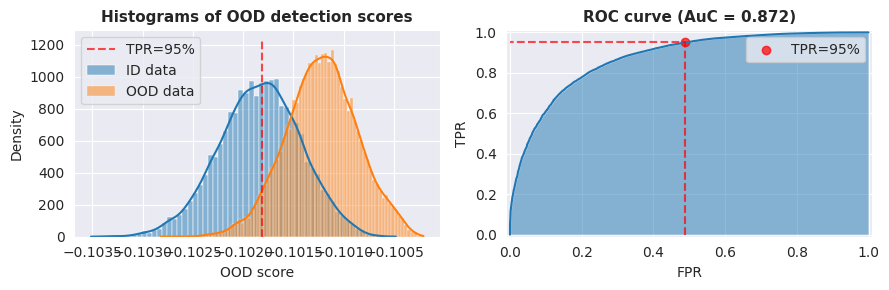

~ With ASH ~
auroc      0.397390
fpr95tpr   0.951300


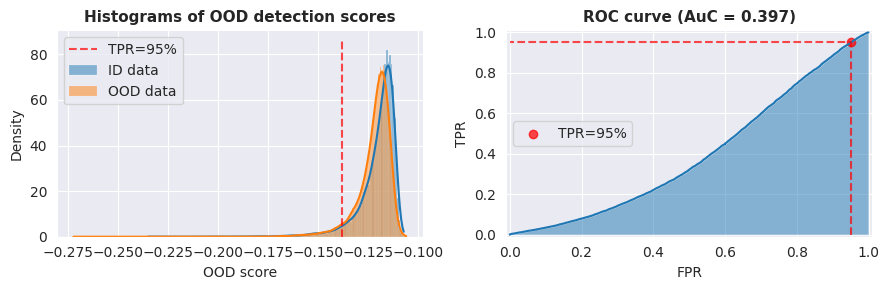

=== MLS ===
~ Without ASH ~
auroc      0.904973
fpr95tpr   0.303800


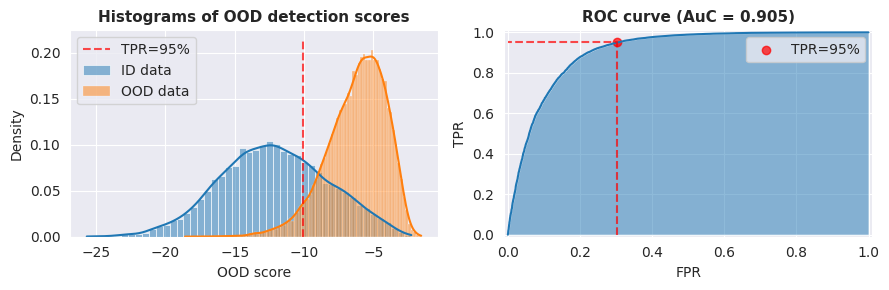

~ With ASH ~
auroc      0.355637
fpr95tpr   0.970900


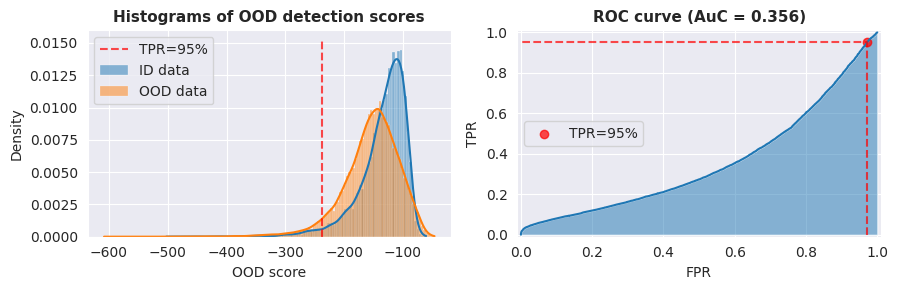

=== ENERGY ===
~ Without ASH ~
auroc      0.906344
fpr95tpr   0.302700


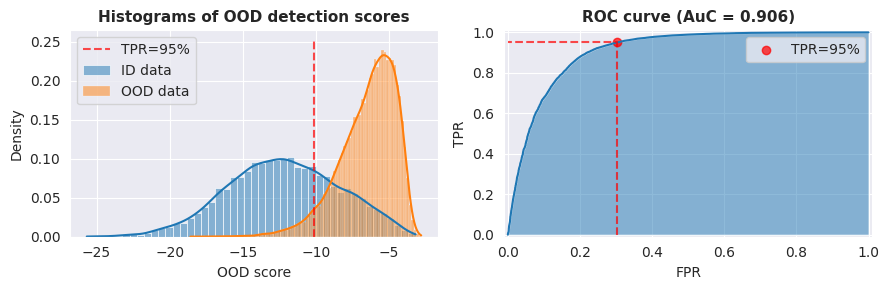

~ With ASH ~
auroc      0.355594
fpr95tpr   0.970900


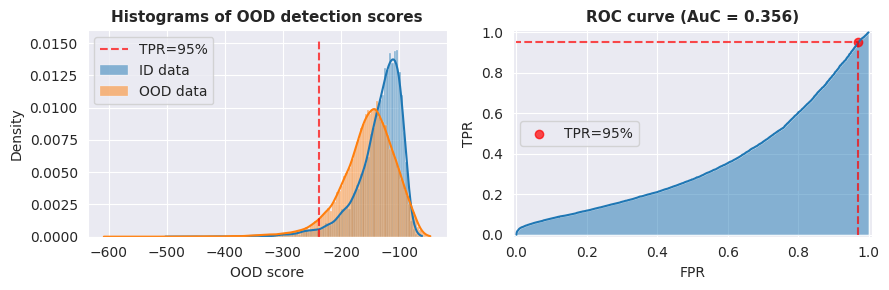

In [6]:
detectors = {
    "odin": {
        "class": ODIN,
        "kwargs": dict(temperature=1000),
    },
    "mls": {
        "class": MLS,
        "kwargs": dict(),
    },
    "energy": {
        "class": Energy,
        "kwargs": dict(),
    },
}

for d in detectors.keys():
    print(f"=== {d.upper()} ===")

    for use_ash in [False, True]:
        print(["~ Without", "~ With"][int(use_ash)] + " ASH ~")
        # === ood scores ===
        d_kwargs = detectors[d]["kwargs"]
        d_kwargs.update(
            dict(
                use_ash=use_ash,
                ash_percentile=0.90,
            )
        )
        detector = detectors[d]["class"](**d_kwargs)
        detector.fit(model)
        scores_in, _ = detector.score(ds_in)
        scores_out, _ = detector.score(ds_out)

        # === metrics ===
        # auroc / fpr95
        metrics = bench_metrics(
            (scores_in, scores_out),
            metrics=["auroc", "fpr95tpr"],
        )
        for k, v in metrics.items():
            print(f"{k:<10} {v:.6f}")

        # hists / roc
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        plot_ood_scores(scores_in, scores_out)
        plt.subplot(122)
        plot_roc_curve(scores_in, scores_out)
        plt.tight_layout()
        plt.show()